In [1]:
import pandas as pd
import numpy as np
from random import randrange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# 排除警告信息
import warnings
# matplotlib画图常见参数设置
mpl.rcParams["font.family"] = "SimHei" 
# 设置字体
mpl.rcParams["axes.unicode_minus"]=False 
# 用来正常显示负号
plt.rcParams['font.sans-serif']=['SimHei'] 
# 用来正常显示中文标签# 嵌入式显示图形
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
raw_data=pd.read_excel('E:/data analy/data.xlsx',sheet_name='data',encoding='utf-8')
raw_data.shape

(84, 17)

In [4]:
data=raw_data[8:]

In [5]:
times=[]
for i in data['单位：亿美元']:
    time=str(2000+int(i[2:]))+'-'+str(int(i[1])*3)
    times.append(time)
data['time']=times
pd.to_datetime(data['time'],format='%Y%m',errors='coerce')
del data['单位：亿美元']
data.set_index(data['time'],drop=True, append=False, inplace=True)
del data['time']
data.head()

,2G北美规模,3G北美规模,4G北美规模,北美整体规模,2G EMEA规模,3G EMEA规模,4G EMEA规模,EMEA整体规模,2G亚太规模,3G亚太规模,4G亚太规模,亚太整体规模,2G CALA规模,3G CALA规模,4G CALA规模,CALA整体规模
time,,,,,,,,,,,,,,,,
2001-3,20.487651,NaN,NaN,20.487651,32.408111,NaN,NaN,32.408111,25.475765,2.056635,NaN,27.532400,4.066622,NaN,NaN,4.066622
2001-6,23.834362,NaN,NaN,23.834362,36.965381,NaN,NaN,36.965381,30.731792,2.212966,NaN,32.944758,7.799611,NaN,NaN,7.799611
2001-9,23.069302,NaN,NaN,23.069302,29.223739,NaN,NaN,29.223739,25.420250,2.218115,NaN,27.638365,6.187955,NaN,NaN,6.187955
2001-12,22.181998,NaN,NaN,22.181998,30.496873,NaN,NaN,30.496873,23.708811,2.067621,NaN,25.776432,4.361979,NaN,NaN,4.361979
2002-3,21.591055,NaN,NaN,21.591055,24.674127,NaN,NaN,24.674127,21.917765,2.151744,NaN,24.069508,5.172252,NaN,NaN,5.172252


In [6]:
overall=data[['北美整体规模','EMEA整体规模','亚太整体规模','CALA整体规模']]
overall.interpolate(meth='time',inplace=True)
overall.isna().sum()

北美整体规模      0
EMEA整体规模    0
亚太整体规模      0
CALA整体规模    0
dtype: int64

<Figure size 432x288 with 0 Axes>

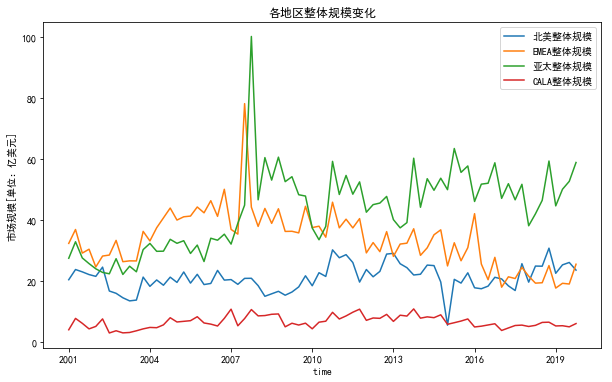

In [7]:
# 绘制时序图
plt.figure()
overall.plot(figsize=(10,6))
plt.title('各地区整体规模变化')
plt.ylabel('市场规模[单位：亿美元]')
years=range(2001,2019,5)
plt.xticks(np.arange(0,76,12),list(range(2001,2020,3)))
plt.show()

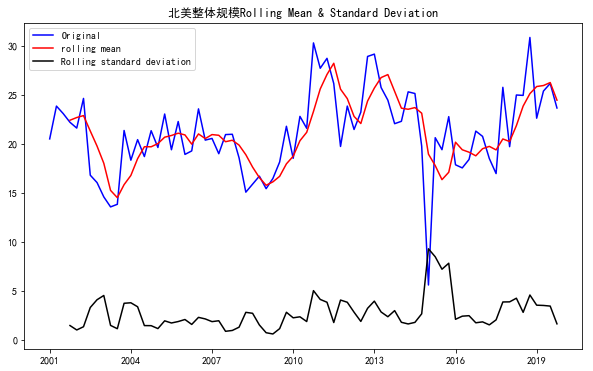

Results of Dickey-Fuller Test:
Test Statistic                 -3.320709
p-value                         0.013978
#Lags Used                      1.000000
Number of Observations Used    74.000000
Critical value (1%)            -3.521980
Critical value (5%)            -2.901470
Critical value (10%)           -2.588072
dtype: float64


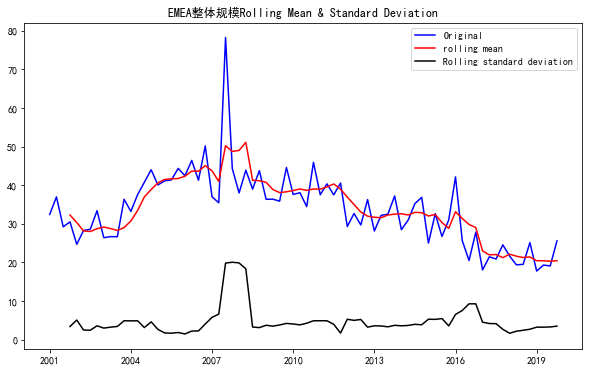

Results of Dickey-Fuller Test:
Test Statistic                 -0.943193
p-value                         0.773416
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical value (1%)            -3.524624
Critical value (5%)            -2.902607
Critical value (10%)           -2.588679
dtype: float64


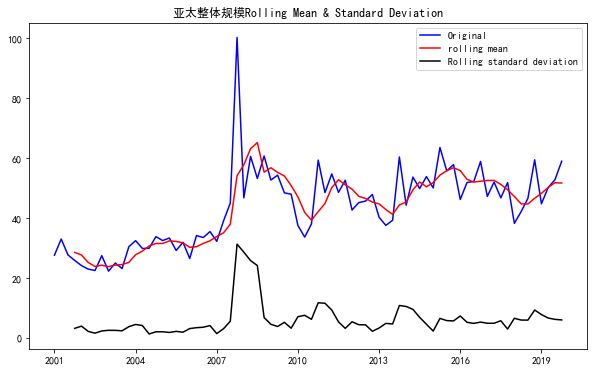

Results of Dickey-Fuller Test:
Test Statistic                 -1.823407
p-value                         0.368904
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical value (1%)            -3.524624
Critical value (5%)            -2.902607
Critical value (10%)           -2.588679
dtype: float64


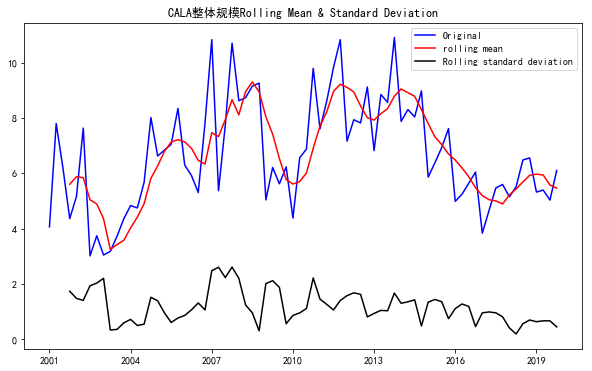

Results of Dickey-Fuller Test:
Test Statistic                 -2.545136
p-value                         0.104875
#Lags Used                      4.000000
Number of Observations Used    71.000000
Critical value (1%)            -3.526005
Critical value (5%)            -2.903200
Critical value (10%)           -2.588995
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=4).mean()
    rolstd = pd.Series.rolling(timeseries, window=4).std()
    name=timeseries.name
    #plot rolling statistics:
    fig = plt.figure(figsize=(10,6))
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    
    plt.legend(loc = 'best')
    plt.title(name+'Rolling Mean & Standard Deviation')
    years=range(2001,2019,5)
    plt.xticks(np.arange(0,76,12),list(range(2001,2020,3)))
    plt.show(block=False)
    #Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
for i in overall.columns:
    st_area = overall[i]
    test_stationarity(st_area)

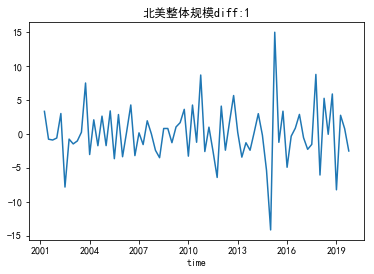

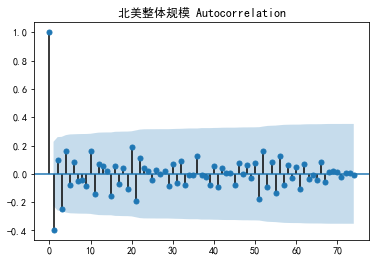

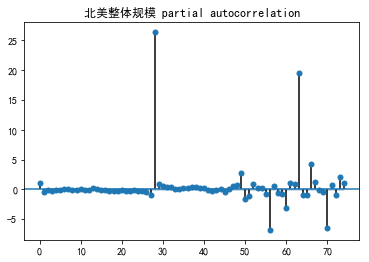

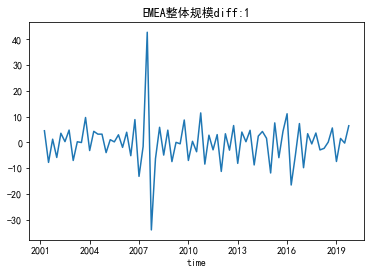

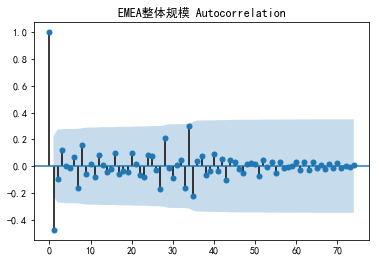

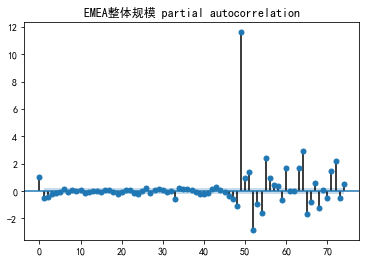

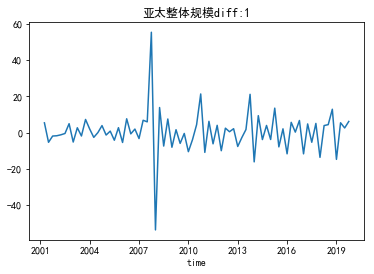

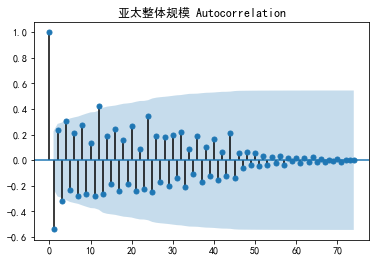

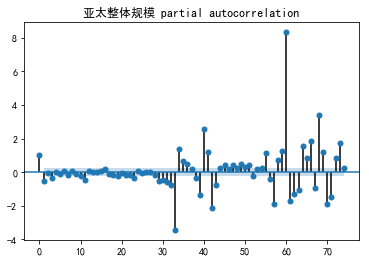

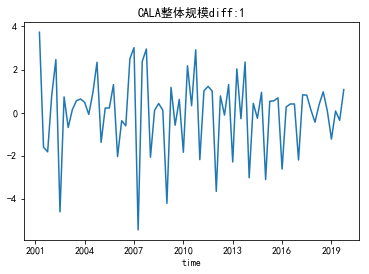

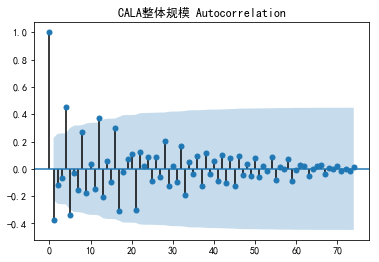

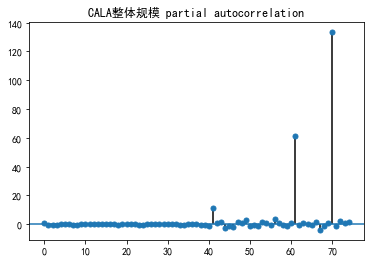

In [9]:
def diff_timeseries(df):
    # 默认1阶差分
    overall_diff = df.diff(periods=1)
    # 差分后需要排空，
    name=df.name
    overall_diff.plot()
    plt.title(name+'diff:1')
    years=range(2001,2019,5)
    plt.xticks(np.arange(0,76,12),list(range(2001,2020,3)))
    overall_diff = overall_diff.dropna()
    tit1=name+' Autocorrelation'
    plot_acf(overall_diff,title=tit1)
    tit2=name+' partial autocorrelation'
    plot_pacf(overall_diff,title=tit2)
    plt.show()
for i in overall.columns:
    t=overall[i]
    diff_timeseries(t)

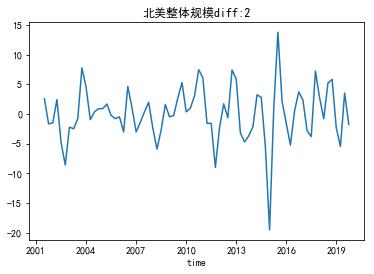

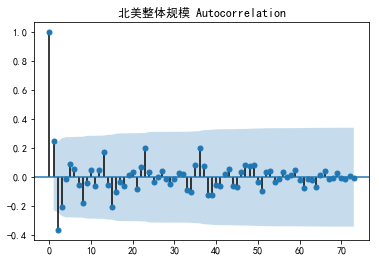

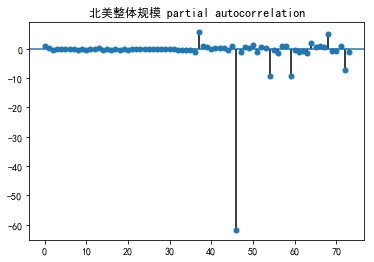

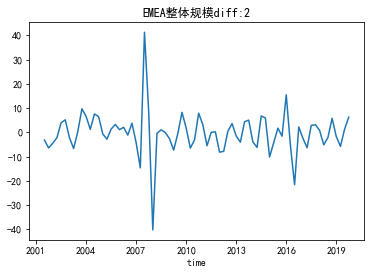

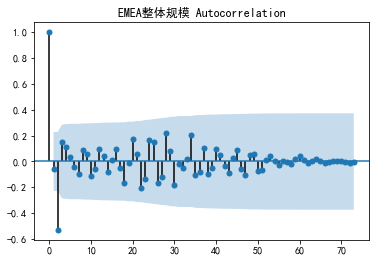

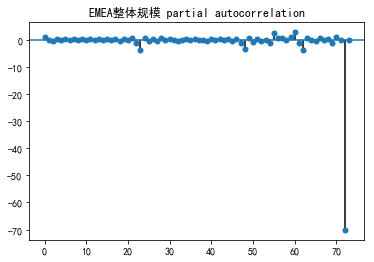

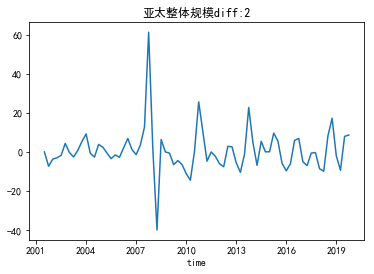

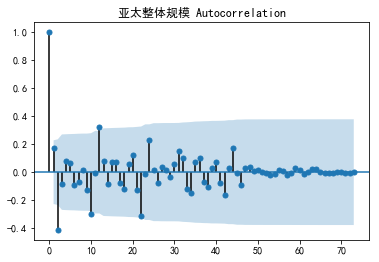

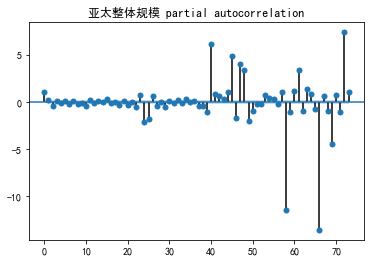

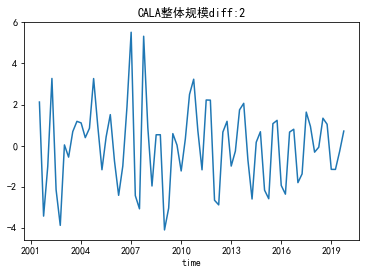

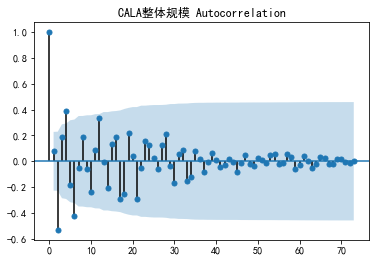

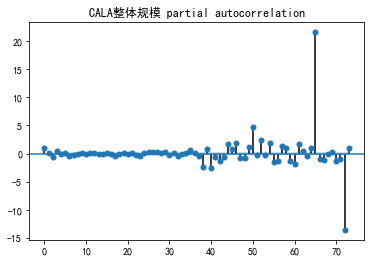

In [10]:
def diff_timeseries2(df):
    # 默认1阶差分
    overall_diff = df.diff(periods=2)
    # 差分后需要排空，
    name=df.name
    overall_diff.plot()
    plt.title(name+'diff:2')
    years=range(2001,2019,5)
    plt.xticks(np.arange(0,76,12),list(range(2001,2020,3)))
    overall_diff = overall_diff.dropna()
    tit1=name+' Autocorrelation'
    plot_acf(overall_diff,title=tit1)
    tit2=name+' partial autocorrelation'
    plot_pacf(overall_diff,title=tit2)
    plt.show()
for i in overall.columns:
    t=overall[i]
    diff_timeseries2(t)

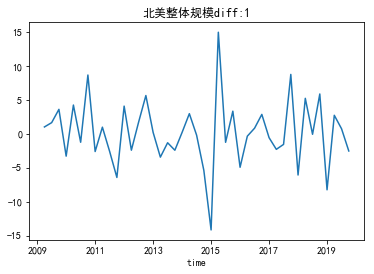

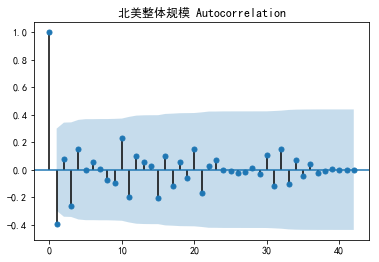

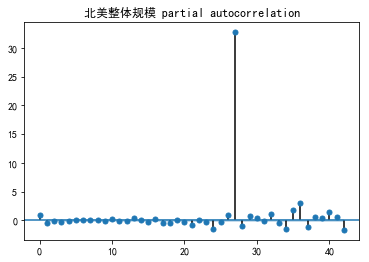

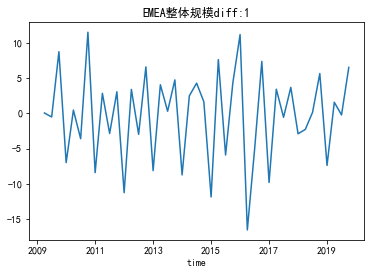

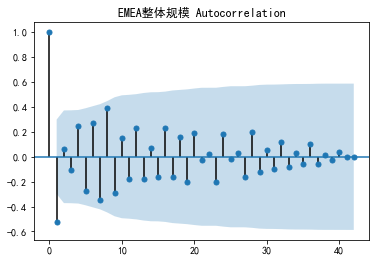

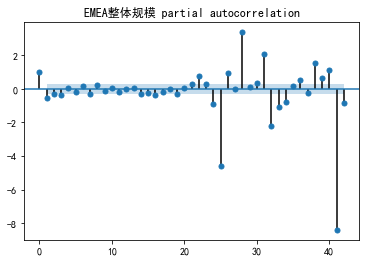

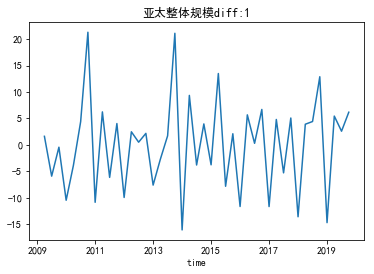

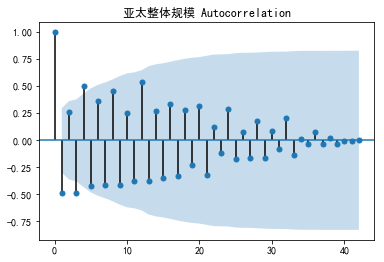

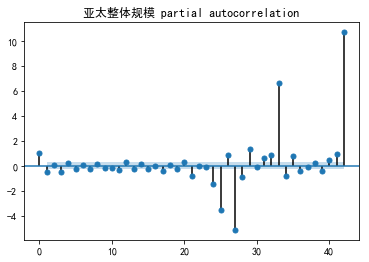

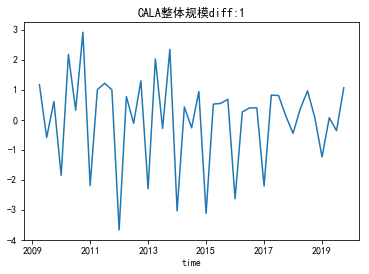

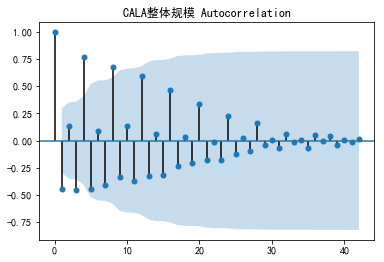

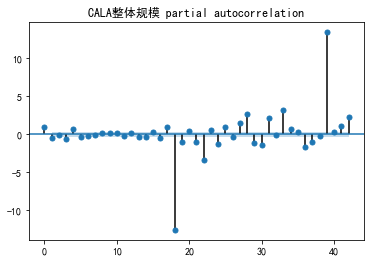

In [11]:
def diff_timeseries(df):
    # 默认1阶差分
    overall_diff = df.diff(periods=1)
    # 差分后需要排空，
    name=df.name
    overall_diff.plot()
    plt.title(name+'diff:1')
    years=range(2009,2020,2)
    plt.xticks(np.arange(0,44,8),list(years))
    overall_diff = overall_diff.dropna()
    tit1=name+' Autocorrelation'
    plot_acf(overall_diff,title=tit1)
    tit2=name+' partial autocorrelation'
    plot_pacf(overall_diff,title=tit2)
    plt.show()
for i in overall.columns:
    t=overall[i][32:]
    diff_timeseries(t)

In [12]:
diff1=overall.diff(periods=1)
diff1.dropna(inplace=True)
diff1.head()

,北美整体规模,EMEA整体规模,亚太整体规模,CALA整体规模
time,,,,
2001-6,3.346711,4.557270,5.412358,3.732989
2001-9,-0.765060,-7.741642,-5.306393,-1.611657
2001-12,-0.887304,1.273134,-1.861933,-1.825976
2002-3,-0.590944,-5.822746,-1.706924,0.810273
2002-6,3.027222,3.580813,-1.181803,2.460899


In [15]:
#北美
bmdiff1=diff1['北美整体规模']
BMarma_mod50 = sm.tsa.ARMA(bmdiff1,(5,0)).fit()
print("arma_mod50:",BMarma_mod50.aic,BMarma_mod50.bic,BMarma_mod50.hqic)
BMarma_mod01 = sm.tsa.ARMA(bmdiff1,(0,1)).fit()
print("arma_mod01:",BMarma_mod01.aic,BMarma_mod01.bic,BMarma_mod01.hqic)
BMarma_mod51 = sm.tsa.ARMA(bmdiff1,(4,1)).fit()
print("arma_mod51:",BMarma_mod51.aic,BMarma_mod51.bic,BMarma_mod51.hqic)

arma_mod50: 421.6279821801609 437.8503989749151 428.1054150713974
arma_mod01: 417.3944456389908 424.34690997959973 420.1704883066636
arma_mod51: 416.52765592906405 432.7500727238182 423.0050888203005


In [16]:
#EMEA
emdiff1=diff1['EMEA整体规模']
EMarma_mod40 = sm.tsa.ARMA(emdiff1,(4,0)).fit()
print("arma_mod50:",EMarma_mod40.aic,EMarma_mod40.bic,EMarma_mod40.hqic)
EMarma_mod01 = sm.tsa.ARMA(emdiff1,(0,1)).fit()
print("arma_mod01:",EMarma_mod01.aic,EMarma_mod01.bic,EMarma_mod01.hqic)
EMarma_mod41 = sm.tsa.ARMA(emdiff1,(4,1)).fit()
print("arma_mod51:",EMarma_mod41.aic,EMarma_mod41.bic,EMarma_mod41.hqic)
EMarma_mod91 = sm.tsa.ARMA(emdiff1,(9,1)).fit()
print("arma_mod51:",EMarma_mod91.aic,EMarma_mod91.bic,EMarma_mod91.hqic)

arma_mod50: 508.8414260466428 522.7463547278606 514.3935113819883
arma_mod01: 506.64577817606994 513.5982425166789 509.4218208437427
arma_mod51: 510.80829508901513 527.0307118837693 517.2857279802515
arma_mod51: 517.2372871579936 545.0471445204294 528.3414578286846


In [17]:
#亚太
ytdiff1=diff1['亚太整体规模']
YTarma_mod70 = sm.tsa.ARMA(ytdiff1,(7,0)).fit()
print("arma_mod50:",YTarma_mod70.aic,YTarma_mod70.bic,YTarma_mod70.hqic)
YTarma_mod01 = sm.tsa.ARMA(ytdiff1,(0,1)).fit()
print("arma_mod01:",YTarma_mod01.aic,YTarma_mod01.bic,YTarma_mod01.hqic)
YTarma_mod71 = sm.tsa.ARMA(ytdiff1,(7,1)).fit()
print("arma_mod51:",YTarma_mod71.aic,YTarma_mod71.bic,YTarma_mod71.hqic)

arma_mod50: 561.8087745698961 582.6661675917228 570.1369025729143
arma_mod01: 557.6705704659914 564.6230348066003 560.4466131336642
arma_mod51: 559.9634317576159 583.138312892979 569.2169073165251


In [31]:
#亚太
ytdiff1=diff1['亚太整体规模']
YTarma_mod70 = sm.tsa.ARMA(ytdiff1,(7,0)).fit()
print("arma_mod70:",YTarma_mod70.aic,YTarma_mod70.bic,YTarma_mod70.hqic)
YTarma_mod02 = sm.tsa.ARMA(ytdiff1,(0,2)).fit()
print("arma_mod02:",YTarma_mod02.aic,YTarma_mod02.bic,YTarma_mod02.hqic)
YTarma_mod72 = sm.tsa.ARMA(ytdiff1,(6,2)).fit()
print("arma_mod62:",YTarma_mod72.aic,YTarma_mod72.bic,YTarma_mod72.hqic)

arma_mod70: 561.8087745698961 582.6661675917228 570.1369025729143
arma_mod02: 559.539070934212 568.8090233883572 563.2404611577756
arma_mod62: 557.0356857056795 580.2105668410426 566.2891612645886


In [18]:
#cal
cadiff1=diff1['CALA整体规模']
YTarma_mod60 = sm.tsa.ARMA(cadiff1,(6,0)).fit()
print("arma_mod50:",YTarma_mod60.aic,YTarma_mod60.bic,YTarma_mod60.hqic)
YTarma_mod01 = sm.tsa.ARMA(cadiff1,(0,1)).fit()
print("arma_mod01:",YTarma_mod01.aic,YTarma_mod01.bic,YTarma_mod01.hqic)
YTarma_mod61 = sm.tsa.ARMA(cadiff1,(6,1)).fit()
print("arma_mod51:",YTarma_mod61.aic,YTarma_mod61.bic,YTarma_mod61.hqic)

arma_mod50: 278.2939311059829 296.8338360142734 285.6967115531102
arma_mod01: 286.3532960701633 293.3057604107722 289.12933873783606
arma_mod51: 274.1749092886881 295.0323023105149 282.5030372917064


In [35]:
#北美 0,1,1
#EM 0,1,1
#亚太 0,1,1
#CA 6,1,1
bmarima = ARIMA(overall['北美整体规模'], order=(0, 1, 1))
emarima = ARIMA(overall['EMEA整体规模'], order=(0, 1, 1))
ytarima = ARIMA(overall['亚太整体规模'], order=(6, 1, 1))
caarima = ARIMA(overall['CALA整体规模'], order=(6, 1, 1))
bmresult = bmarima.fit(disp=True)
emresult = emarima.fit(disp=True)
ytresult = ytarima.fit(disp=True)
caresult = caarima.fit(disp=True)

In [48]:
bmmod = sm.tsa.statespace.SARIMAX(overall['北美整体规模'],
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
emmod = sm.tsa.statespace.SARIMAX(overall['EMEA整体规模'],
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
ytmod = sm.tsa.statespace.SARIMAX(overall['亚太整体规模'],
                                order=(6, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
camod = sm.tsa.statespace.SARIMAX(overall['CALA整体规模'],
                                order=(6, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
 
print(bmmod.summary().tables[1]) #详细输出，results.summary()可以输出全部的模型计算参数表
print(emmod.summary().tables[1])
print(ytmod.summary().tables[1])
print(camod.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4312      0.087     -4.980      0.000      -0.601      -0.262
ar.S.L4    -5.929e-05      0.171     -0.000      1.000      -0.336       0.336
ma.S.L4       -1.0000   1897.387     -0.001      1.000   -3719.810    3717.810
sigma2        13.7465   2.61e+04      0.001      1.000   -5.11e+04    5.11e+04
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6803      0.109     -6.230      0.000      -0.894      -0.466
ar.S.L4       -0.0017      0.017     -0.100      0.921      -0.035       0.032
ma.S.L4       -1.0000   2082.932     -0.000      1.000   -4083.471    4081.471
sigma2        44.2366   9.21e+04      0.000      1.000   -1.81e+05    1.81e+05
                 coef    std err          z      P>|

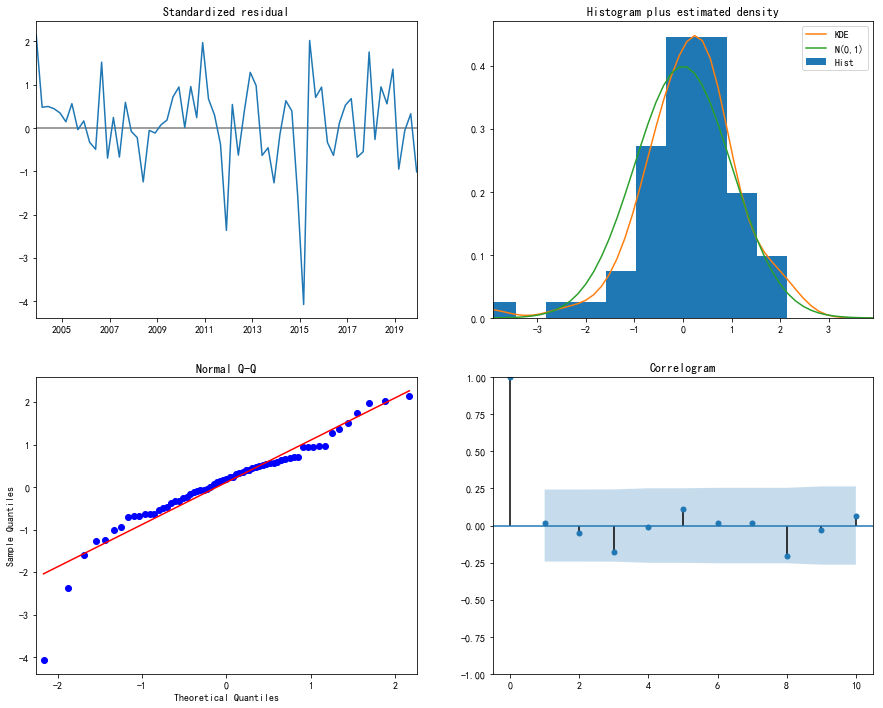

In [49]:
bmmod.plot_diagnostics(figsize=(15, 12))
plt.show()

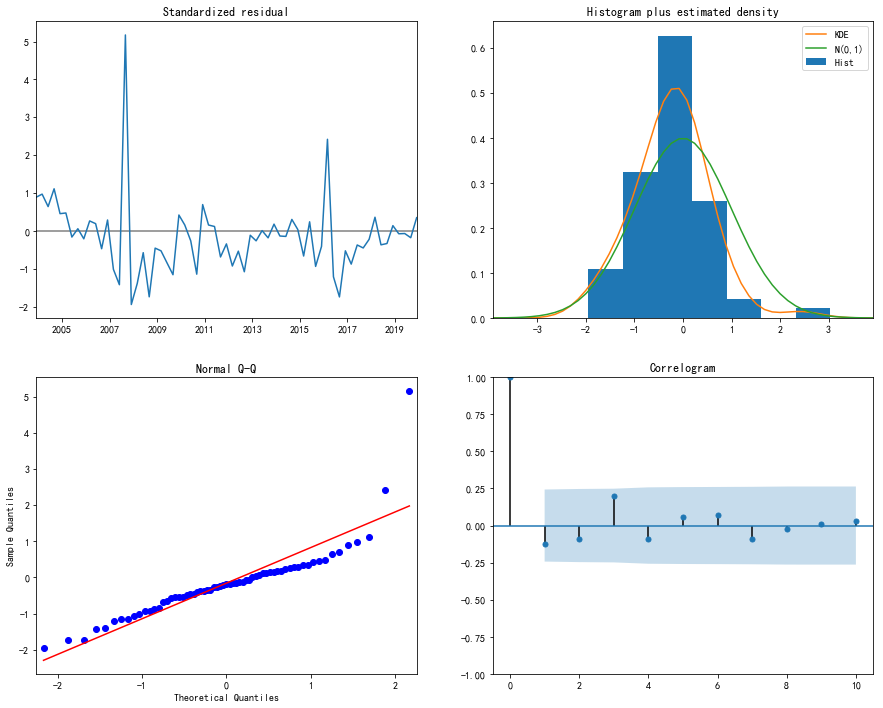

In [50]:
emmod.plot_diagnostics(figsize=(15, 12))
plt.show()

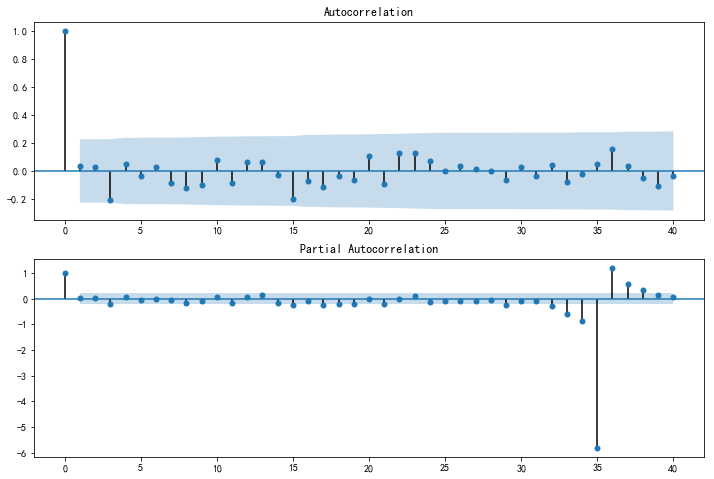

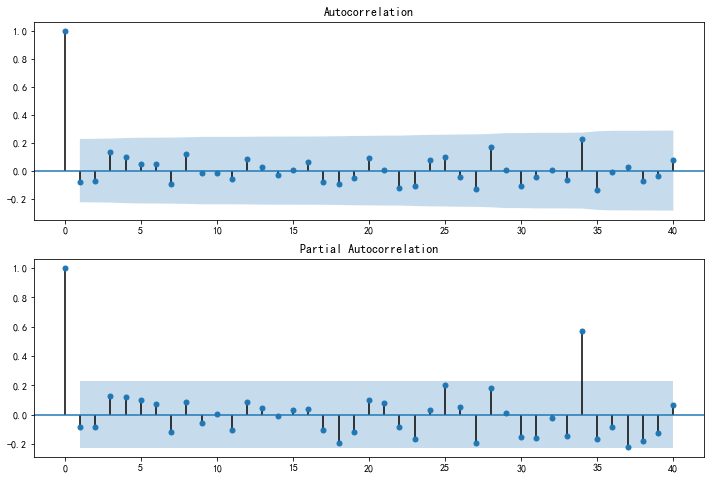

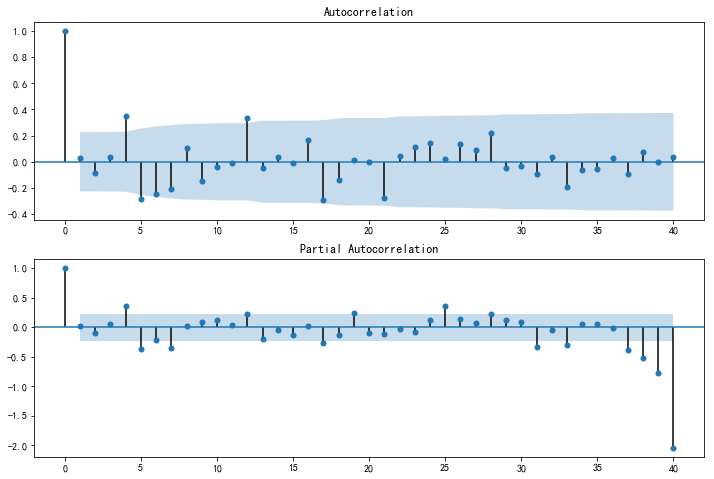

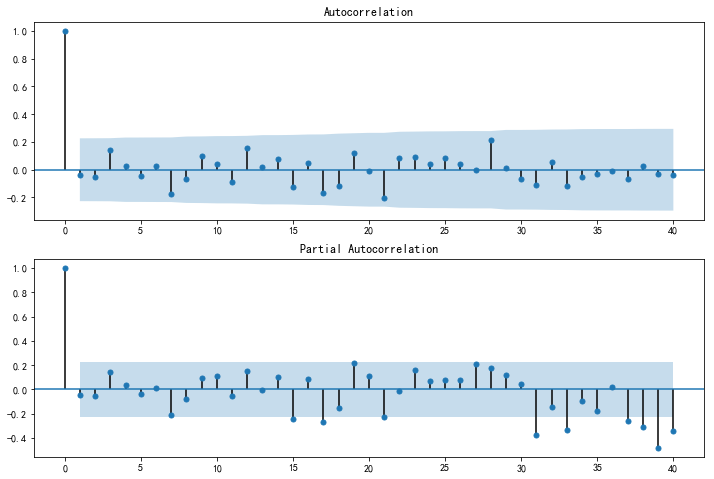

In [23]:
model_list1=[BMarma_mod01,EMarma_mod01,YTarma_mod01,YTarma_mod61]
for md in model_list:
    resid = md.resid 
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
    plt.show()


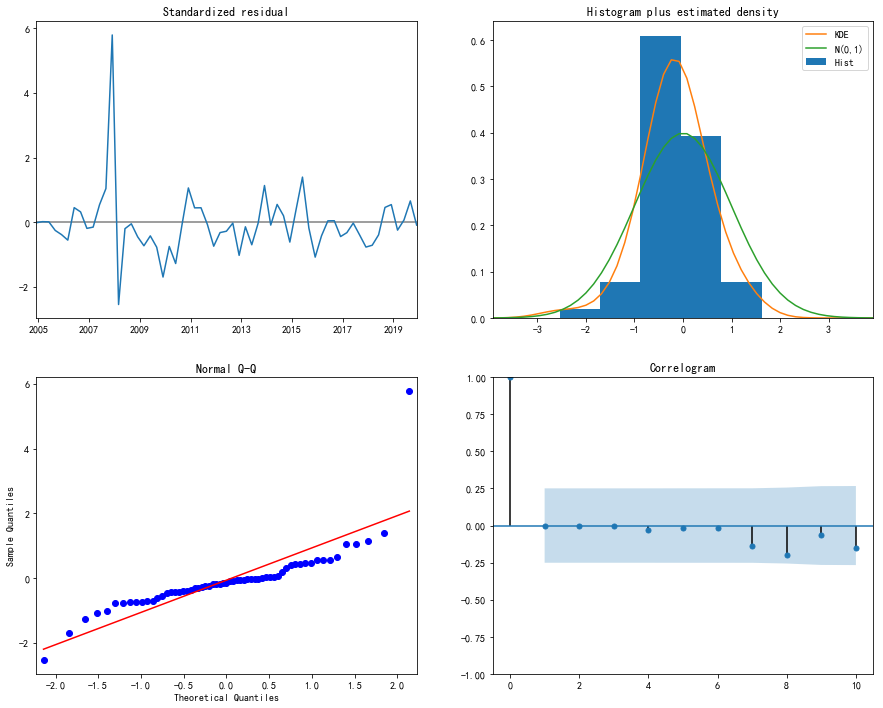

In [51]:
ytmod.plot_diagnostics(figsize=(15, 12))
plt.show()

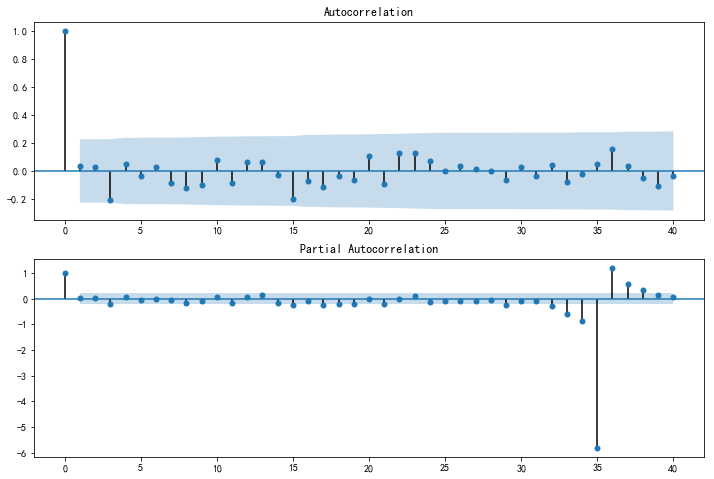

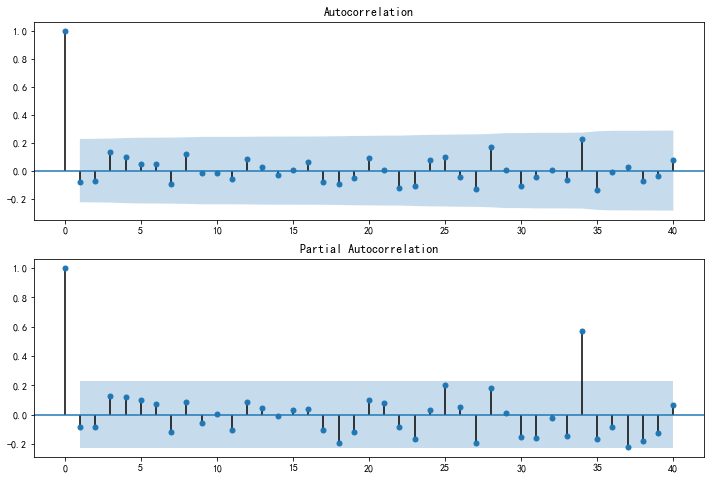

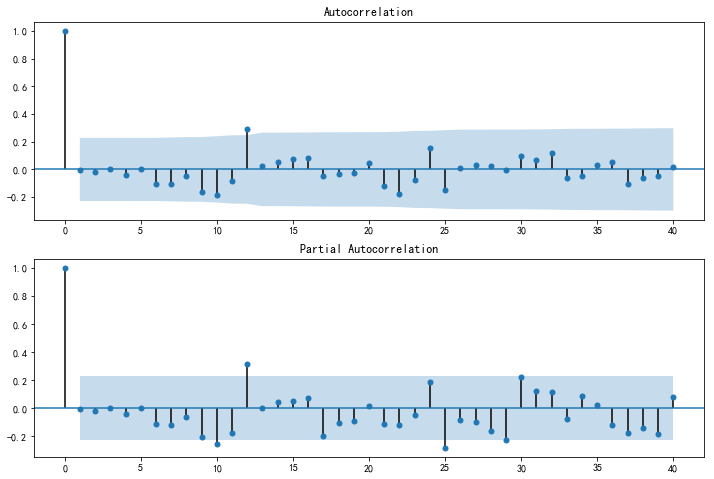

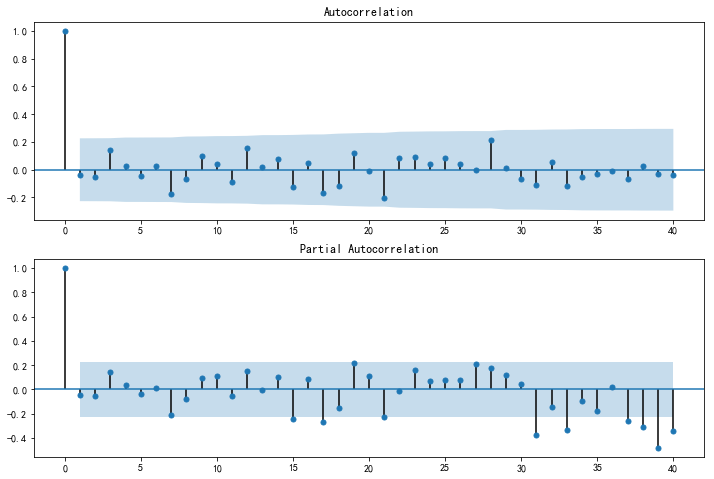

In [33]:
model_list1=[bmresult,emresult,ytresult,caresult]
for md in model_list1:
    resid = md.resid 
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
    plt.show()

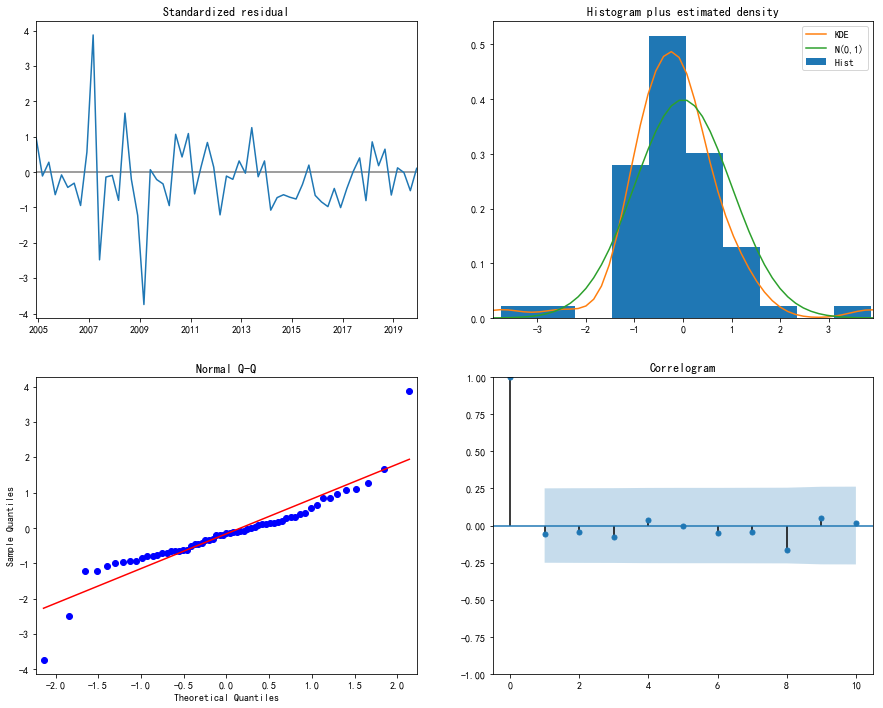

In [52]:
camod.plot_diagnostics(figsize=(15, 12))
plt.show()

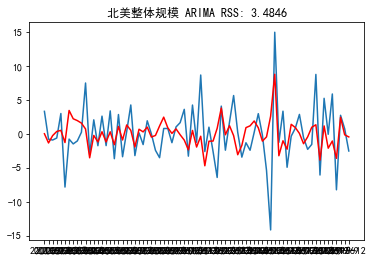

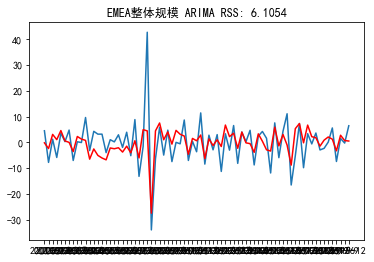

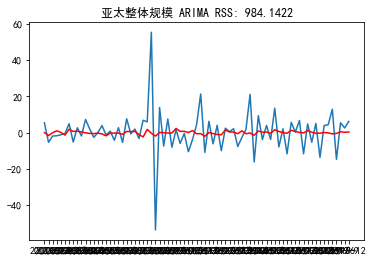

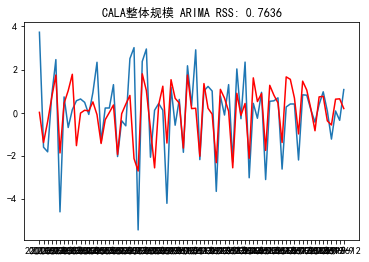

In [36]:
dif_list=[bmdiff1,emdiff1,ytdiff1,cadiff1]
name_list=['北美整体规模','EMEA整体规模','亚太整体规模','CALA整体规模']
for i in range(4):
    plt.plot(dif_list[i])
    plt.plot(model_list[i].fittedvalues, color='red')
    plt.title(name_list[i]+' ARIMA RSS: %.4f' % sum(model_list[i].fittedvalues - dif_list[i]) ** 2)
    plt.show()

In [ ]:
dif_list=[bmdiff1,emdiff1,ytdiff1,cadiff1]
name_list=['北美整体规模','EMEA整体规模','亚太整体规模','CALA整体规模']
for i in range(4):
    plt.plot(dif_list[i])
    plt.plot(model_list[i].fittedvalues, color='red')
    plt.title(name_list[i]+' ARIMA RSS: %.4f' % sum(model_list[i].fittedvalues - dif_list[i]) ** 2)
    plt.show()

In [39]:
overall.index = pd.DatetimeIndex(overall.index)

In [57]:
pred = bmmod.get_prediction('2010-3', '2020-12', dynamic=False)#预测值
pred_ci = pred.conf_int()#置信区间
pre=pred.predicted_mean

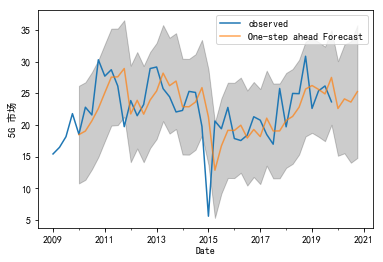

In [59]:
pred = bmmod.get_prediction('2010-3', '2020-12', dynamic=False)#预测值
pred_ci = pred.conf_int()#置信区间
ax = overall.ix[32:,'北美整体规模'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
#图形填充fill fill_between，参考网址：
#https://www.cnblogs.com/gengyi/p/9416845.html
 
ax.set_xlabel('Date')
ax.set_ylabel('5G 市场')
plt.legend()
 
plt.show()

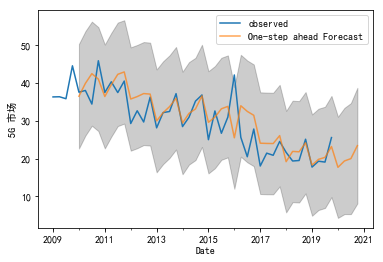

In [63]:
pred1= emmod.get_prediction('2010-3', '2020-12', dynamic=False)#预测值
pred_ci1 = pred1.conf_int()#置信区间
ax = overall.ix[32:,'EMEA整体规模'].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.2)
#图形填充fill fill_between，参考网址：
#https://www.cnblogs.com/gengyi/p/9416845.html
 
ax.set_xlabel('Date')
ax.set_ylabel('5G 市场')
plt.legend()
 
plt.show()

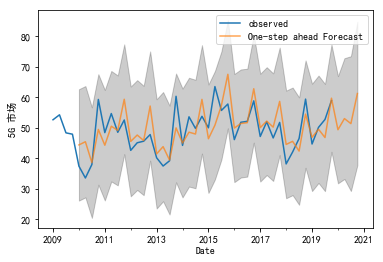

In [65]:
pred2= ytmod.get_prediction('2010-3', '2020-12', dynamic=False)#预测值
pred_ci2 = pred2.conf_int()#置信区间
ax = overall.ix[32:,'亚太整体规模'].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)
#图形填充fill fill_between，参考网址：
#https://www.cnblogs.com/gengyi/p/9416845.html
 
ax.set_xlabel('Date')
ax.set_ylabel('5G 市场')
plt.legend()
 
plt.show()

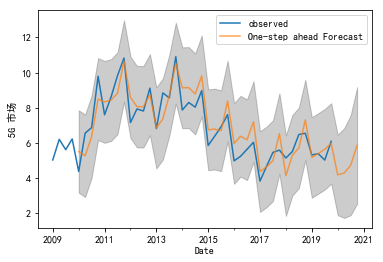

In [67]:
pred3= camod.get_prediction('2010-3', '2020-12', dynamic=False)#预测值
pred_ci3 = pred3.conf_int()#置信区间
ax = overall.ix[32:,'CALA整体规模'].plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.2)
#图形填充fill fill_between，参考网址：
#https://www.cnblogs.com/gengyi/p/9416845.html
 
ax.set_xlabel('Date')
ax.set_ylabel('5G 市场')
plt.legend()
 
plt.show()

In [69]:
prediction=pd.DataFrame({'北美整体规模':pred.predicted_mean})

In [71]:
prediction['EMEA整体规模']=pred1.predicted_mean
prediction['亚太整体规模']=pred2.predicted_mean
prediction['CALA整体规模']=pred3.predicted_mean

5G各市场占比预测，用4G出现时市场占比预测5G,其中变动因子为5G相对于4G传输性能的变化

2.7K 3.78M 50M 1G （2g,3g,4g,5g传输速率）

In [84]:
f=overall['2010-12':'2011-9'].mean()
b=overall['2009-12':'2010-9'].mean()
#4G出现时市场规模变化比例
l=f/b
#4G相对于3G的提升
rate=(l-1)/(50/3.78)

In [89]:
rate

北美整体规模      0.025175
EMEA整体规模    0.003231
亚太整体规模      0.026024
CALA整体规模    0.037029
dtype: float64

In [90]:
#5G下市场应该增长的规模
fiveG=rate*(1024/50)
fiveG

北美整体规模      0.515593
EMEA整体规模    0.066170
亚太整体规模      0.532977
CALA整体规模    0.758364
dtype: float64

In [101]:
#市场整体规模
bm=prediction['2020-3':'2020-12']['北美整体规模']*(1+fiveG[0])
em=prediction['2020-3':'2020-12']['EMEA整体规模']*(1+fiveG[1])
yt=prediction['2020-3':'2020-12']['亚太整体规模']*(1+fiveG[2])
ca=prediction['2020-3':'2020-12']['CALA整体规模']*(1+fiveG[3])

In [102]:
pre_5G=pd.DataFrame({'5G北美整体规模':bm,'5GEMEA整体规模':em,'5G亚太整体规模':yt,'5GCALA整体规模':ca})

In [117]:
#5G占比预测，利用4G占比，乘以5G地区增长因子
bm5zb=data['2010-12':'2011-9']['4G北美规模'].sum()/data['2009-12':'2010-9']['北美整体规模'].sum()
bmzb=zhanbifiveG*(1+fiveG[0])
em5zb=data['2010-12':'2011-9']['4G EMEA规模'].sum()/data['2009-12':'2010-9']['EMEA整体规模'].sum()
emzb=zhanbifiveG*(1+fiveG[1])
yt5zb=data['2010-12':'2011-9']['4G亚太规模'].sum()/data['2009-12':'2010-9']['亚太整体规模'].sum()
ytzb=zhanbifiveG*(1+fiveG[2])
ca5zb=data['2011-12':'2012-9']['4G CALA规模'].sum()/data['2010-12':'2011-9']['CALA整体规模'].sum()
cazb=zhanbifiveG*(1+fiveG[3])
print(bmzb,emzb,ytzb,cazb)

0.24143007346428016 0.169838197501172 0.2441993326694658 0.2801028539745112


In [119]:
pre_5G['5G北美规模']=pre_5G['5G北美整体规模']*bmzb
pre_5G['5GEMEA规模']=pre_5G['5GEMEA整体规模']*emzb
pre_5G['5G亚太规模']=pre_5G['5G亚太整体规模']*ytzb
pre_5G['5GCALA规模']=pre_5G['5GCALA整体规模']*cazb

In [122]:
pre_5G

,5G北美整体规模,5GEMEA整体规模,5G亚太整体规模,5GCALA整体规模,5G北美规模,5GEMEA规模,5G亚太规模,5GCALA规模
2020-03-01,34.233652,18.860573,75.720145,7.369973,8.265033,3.203246,18.490809,2.064351
2020-06-01,36.535097,20.650473,81.325436,7.553201,8.820671,3.507239,19.859617,2.115673
2020-09-01,35.768466,21.323172,78.792941,8.332935,8.635583,3.621489,19.241184,2.334079
2020-12-01,38.274113,24.992739,93.916775,10.313355,9.240522,4.244722,22.934414,2.888800


In [ ]:
bm5zb=data['2010-12':'2011-9']['4G北美规模'].sum()/data['2009-12':'2010-9']['北美整体规模'].sum()
bmzb=zhanbifiveG*(1+fiveG[0])
em5zb=data['2010-12':'2011-9']['4G EMEA规模'].sum()/data['2009-12':'2010-9']['EMEA整体规模'].sum()
emzb=zhanbifiveG*(1+fiveG[1])
yt5zb=data['2010-12':'2011-9']['4G亚太规模'].sum()/data['2009-12':'2010-9']['亚太整体规模'].sum()
ytzb=zhanbifiveG*(1+fiveG[2])
ca5zb=data['2011-12':'2012-9']['4G CALA规模'].sum()/data['2010-12':'2011-9']['CALA整体规模'].sum()
cazb=zhanbifiveG*(1+fiveG[3])
print(bmzb,emzb,ytzb,cazb)